In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [15]:
config = {
    "base_dir":        "/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/FullRun2_v7",
    "plot_config":     "FullRun2_v7",
    "cut":             "res_sig",
    "model_version":   "cugini_scan/v1",
    "model_tag":       "1l_64",
    "samples_version": "v5",
    "cols": [
        "mjj_vbs",
       "Zlep",
#        "vbs_0_E",
#        "vbs_1_E",
         "vbs_0_pt",
         "vbs_1_pt",
#         "deltaeta_vbs",
         "nJets30",
#         "vjet_1_pt",
#         "Lepton_eta",
#         "nJets30",
#         #"PuppiMET_pt",
#         ###"vbs_0_pt",

#         "vjet_0_pt",
#         "vjet_1_pt",
#         "mjj_vbs",
#         "mjj_vjet",
#         "deltaeta_vbs",
#         "deltaphi_vbs",
#         "deltaeta_vjet",
#         "deltaphi_vjet",
#         #"deltaR_lep_vbs",
#         #"deltaphi_lep_nu",
#         #"deltaR_vbs",
#         #"deltaR_vjet",
#         ###"Zvjets_0",
#         #"Zvjets_1",
#         "Zlep",
#         ####"Asym_vbs",
#         #"Mtw_lep",
#         "w_had_pt",
#         #"R_mw",
#         #"A_ww",
#         "Centr_vbs",
#         "Centr_ww",
#         "vbs_0_qglmorphed_res",
#         #"vbs_1_qgl_res",
#         "vjet_0_qglmorphed_res",
#         "vjet_1_qglmorphed_res",
#         #"four_tag_jets_HT",
#         #"four_tag_jets_pt",
#         #"vbs_jets_HT", 
#         #"v_jets_HT",
#         #"vbs_jets_pt"
#         #"cosdeltatheta_Vhad",
#         "cosdeltatheta_vjet_0"        
        ],    
    "test_size": 0.3,
    "val_size":  0.0,
    "optimizer": "adam",
    "batch_size": 64,
    "decay_weights":  'cyclic', #or cyclic
    "decay_weights_pars" : [0.00001,3,0.3], #[0.00005, 0.001, 15000] 
    "patience": [15,0.0001]
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [3]:
len(config["cols"])

5

In [4]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [5]:
print(signal.columns)

Index(['weight', 'Asym_vbs', 'Centr_vbs', 'Centr_ww', 'Lepton_eta',
       'Lepton_phi', 'Lepton_pt', 'Mtw_lep', 'Mww', 'PuppiMET_phi',
       'PuppiMET_pt', 'Zlep', 'Zvjets_0', 'cosdeltatheta_Vhad',
       'cosdeltatheta_lep', 'cosdeltatheta_vjet_0', 'cosdeltatheta_vjet_1',
       'deltaeta_vbs', 'deltaeta_vjet', 'deltaphi_WV', 'deltaphi_vbs',
       'deltaphi_vjet', 'deltatheta_Vhad', 'deltatheta_lep',
       'deltatheta_vjet_0', 'deltatheta_vjet_1', 'mjj_vbs', 'mjj_vjet',
       'nJets30', 'nvtxGood', 'theta_Vhad', 'theta_lep', 'theta_vjet_0',
       'theta_vjet_1', 'vbs_0_eta', 'vbs_0_phi', 'vbs_0_pt',
       'vbs_0_qglmorphed_res', 'vbs_1_eta', 'vbs_1_phi', 'vbs_1_pt',
       'vbs_1_qglmorphed_res', 'vjet_0_eta', 'vjet_0_phi', 'vjet_0_pt',
       'vjet_0_qglmorphed_res', 'vjet_1_eta', 'vjet_1_phi', 'vjet_1_pt',
       'vjet_1_qglmorphed_res', 'w_had_pt', 'w_lep_pt', 'lep_flavour',
       'sample_name', 'year', '_year', 'weight_norm'],
      dtype='object')


## Keras model

In [6]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [9]:
def run(nlayers, nnodes, N, output, drop=0.1, dropout=False, epoche=100, use_weights=False):
    feat = [nnodes] * nlayers
    # import local module that programmatically returns keras models
    import tensorflow as tf
    import dnn_models_cugini
    from dnn_models_au import get_model_au

    X_sig = signal[config["cols"]].values
    X_bkg = bkg[config["cols"]].values
    Y_sig = np.ones(len(X_sig))
    Y_bkg = np.zeros(len(X_bkg))
    W_sig = (signal["weight_norm"]).values
    W_bkg = (bkg["weight_norm"]).values          #if all events are considered the weights are balanced
    Wnn_sig = (signal["weight"]).values
    Wnn_bkg = (bkg["weight"]).values             #weights not balanced

    X = np.vstack([X_sig[:N], X_bkg[:N]])        #all signal first, than all bkg, in arrays of "len(config["cols"])" elements
    Y = np.hstack([Y_sig[:N], Y_bkg[:N]])        #[1. 1. 1. ... 0. 0. 0.]
    W = np.hstack([W_sig[:N], W_bkg[:N]])        #all signal first, than all bkg, in a single big array
    Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

    scaler = StandardScaler() #scales to unit variance and mean zero
    X_scaled = scaler.fit_transform(X) #Fit to data, then transform it
    #pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))
    
    X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=config['test_size'],stratify=Y)
    
    W_train[y_train==0] = W_train[y_train==0] * np.sum(W_train[y_train==1]) / np.sum(W_train[y_train==0])
    W_test[y_test==0] = W_test[y_test==0] * np.sum(W_test[y_test==1]) / np.sum(W_test[y_test==0])
    
    #print(np.sum(W_train[y_train==0]),np.sum(W_train[y_train==1]))
    #print(np.sum(W_test[y_test==0]),np.sum(W_test[y_test==1]))
    
    model = get_model_au(feat, X_train.shape[1], drop, dropout)

    model.compile(optimizer=config["optimizer"],
                loss='binary_crossentropy',
                metrics=['accuracy'])

    model.summary()

    ## TRAINING without random sampling
    import time
    start_time = time.time()
    import tensorflow as tf
    from tensorflow.keras import callbacks
    from tensorflow.keras.optimizers.schedules import InverseTimeDecay

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=config['patience'][1], patience=config['patience'][0], verbose=0, mode='auto', 
                                baseline=None, restore_best_weights=True)

    _callbacks = [early_stopping]


    #if config['decay_weights'] == 'inverse':
    #    lr_scheduler = callbacks.LearningRateScheduler(InverseTimeDecay(*config["decay_weights_pars"]))
    #    _callbacks.append(lr_scheduler)

    #if config['decay_weights'] == 'cyclic':
    #    from callbacks import CyclicLR  
    #    _callbacks.append(CyclicLR(base_lr=config["decay_weights_pars"][0],
    #                                max_lr=config["decay_weights_pars"][1],
    #                                step_size=config["decay_weights_pars"][2],
    #                                mode="triangular2"))

    config["epochs"] = epoche
    
    if use_weights:
        history = model.fit(
                X_train, y_train,
                sample_weight = W_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test, W_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )
    else:
        history = model.fit(
                X_train, y_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )

    config["train_time"] = time.time() - start_time

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()

    # Evalutation
    print(">>> Computing AUC...")

    from sklearn.metrics import roc_auc_score, roc_curve, auc

    pred_test  = model.predict(X_test,  batch_size=2048)
    pred_train = model.predict(X_train, batch_size=2048)
    
    #auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
    #auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
    if use_weights:
        fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test,  sample_weight=W_test)
        fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
    else:
        fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test)
        fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train)
    auc_w_test = auc(fpW_test,tpW_test)
    auc_w_train = auc(fpW_train,tpW_train)

    #print("AUC score: " + str(auc))

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

    # ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
    ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="midnightblue")
    #ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

    ax1.set_xlabel("Bkg contamination", fontsize=18)
    ax1.set_ylabel("Signal efficiency", fontsize=18)

    #ax1.plot([0,1],[1,1],"b--")
    ax1.tick_params("y",labelsize="large")

    ax1.grid()

    ax1.legend(loc=(0.4, 0.5), fontsize="large")

    fig.tight_layout()

    name_model = "{}l_{}_{}var".format(nlayers, nnodes,X_train.shape[1] )
    layers = nlayers
    nodes = nnodes
    nvars = X_train.shape[1]
    ntrain = N
    auc_val = auc_w_test
    auc_train = auc_w_train

    with open(output,"a") as o:
        o.write("{};{};{};{};{};{};{};{}\n".format(name_model, layers, nodes, nvars, ntrain, auc_val, auc_train, epoche))
    
    return X_test, X_train, pred_test, pred_train

>>> Creating model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                384       
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2188/2188 [====

(array([[-0.67052229,  1.13794022, -0.0364064 , -0.06601865, -0.95599971],
        [-0.94594302,  0.18103733, -0.01822953,  0.06353877,  1.96320222],
        [-0.62560252,  0.74741417, -0.89111034, -0.8875376 ,  1.96320222],
        ...,
        [-0.35798263,  1.07672687, -0.38015216, -0.53270345,  1.96320222],
        [ 0.76400179, -0.04787125,  0.97241282, -0.69803568, -0.95599971],
        [ 0.68908254, -0.37947406,  0.12340083,  0.34937743, -0.95599971]]),
 array([[ 1.07354412, -0.11372004, -0.77153071, -0.15923429,  0.0170676 ],
        [-0.94142953,  0.38362337, -1.02238418, -0.82716091, -0.95599971],
        [-0.23836573, -0.21969684,  1.15070278,  1.68476781,  0.0170676 ],
        ...,
        [-0.83347108, -0.28661714,  0.08166248, -0.05485583,  0.0170676 ],
        [-0.14495723, -0.24349994, -1.04459976, -0.75354654,  0.0170676 ],
        [-0.58346001,  0.72194752, -0.24349273, -0.87656002,  0.99013491]]),
 array([[0.55973107],
        [0.16101265],
        [0.12225628],
    

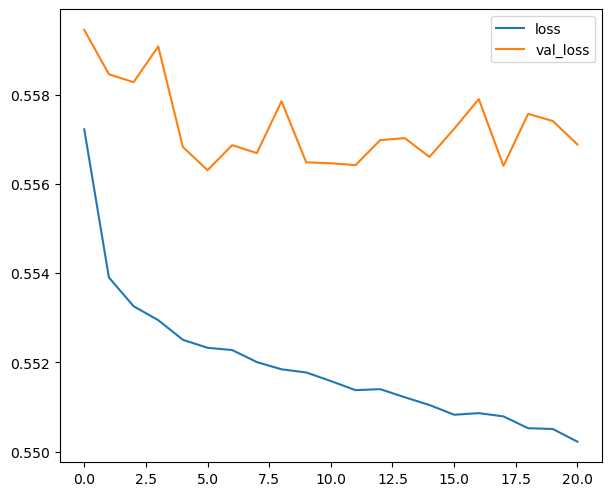

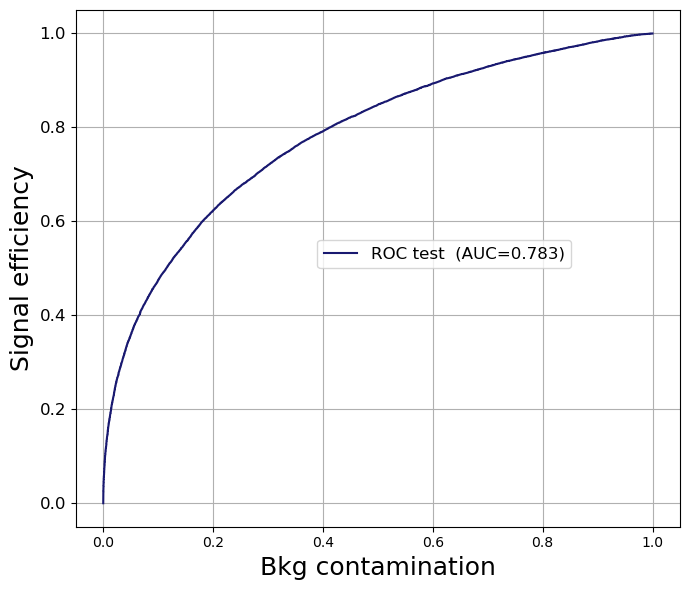

In [16]:
run(4,64, 100000, "test.csv",drop=0.3, dropout=False, epoche=100, use_weights=False)
#cyclic seems better than inverse

316
1 4
>>> Creating model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4)                 24        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 41ms/step - loss: 1.0126 - accuracy: 0.3914 - val_loss: 0.9169 - val_accuracy: 0.4158
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9995 - accuracy: 0.3914 - val_loss: 0.9075 - val_accuracy: 0.4105
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.9873 - accuracy: 0.3891 - val_loss: 0.8982 - val_accuracy: 0.4105
Epoch 

7/7 [==============================] - 0s 8ms/step - loss: 0.6806 - accuracy: 0.5611 - val_loss: 0.6669 - val_accuracy: 0.5737
Epoch 55/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6792 - accuracy: 0.5633 - val_loss: 0.6654 - val_accuracy: 0.5789
Epoch 56/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6777 - accuracy: 0.5679 - val_loss: 0.6642 - val_accuracy: 0.5789
Epoch 57/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6764 - accuracy: 0.5611 - val_loss: 0.6629 - val_accuracy: 0.5842
Epoch 58/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6751 - accuracy: 0.5656 - val_loss: 0.6616 - val_accuracy: 0.5789
Epoch 59/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6740 - accuracy: 0.5679 - val_loss: 0.6604 - val_accuracy: 0.5737
Epoch 60/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6728 - accuracy: 0.5679 - val_loss: 0.6593 - val_accuracy: 0.5632
Epoch 61/100
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.7017 - accuracy: 0.5113 - val_loss: 0.6782 - val_accuracy: 0.5632
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.5158 - val_loss: 0.6726 - val_accuracy: 0.5684
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5204 - val_loss: 0.6674 - val_accuracy: 0.5684
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6862 - accuracy: 0.5430 - val_loss: 0.6629 - val_accuracy: 0.5895
Epoch 11/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6821 - accuracy: 0.5452 - val_loss: 0.6587 - val_accuracy: 0.6158
Epoch 12/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6784 - accuracy: 0.5611 - val_loss: 0.6551 - val_accuracy: 0.6368
Epoch 13/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6751 - accuracy: 0.5633 - val_loss: 0.6517 - val_accuracy: 0.6421
Epoch 14/100
7/7 [=================

7/7 [==============================] - 0s 6ms/step - loss: 0.6368 - accuracy: 0.6222 - val_loss: 0.6141 - val_accuracy: 0.6842
Epoch 66/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6366 - accuracy: 0.6244 - val_loss: 0.6144 - val_accuracy: 0.6842
Epoch 67/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6365 - accuracy: 0.6244 - val_loss: 0.6144 - val_accuracy: 0.6842
Epoch 68/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6363 - accuracy: 0.6222 - val_loss: 0.6145 - val_accuracy: 0.6842
Epoch 69/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6360 - accuracy: 0.6244 - val_loss: 0.6144 - val_accuracy: 0.6842
Epoch 70/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6358 - accuracy: 0.6267 - val_loss: 0.6144 - val_accuracy: 0.6842
>>> Computing AUC...
2 4
>>> Creating model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Sh

7/7 [==============================] - 0s 6ms/step - loss: 0.6252 - accuracy: 0.6199 - val_loss: 0.6619 - val_accuracy: 0.5895
Epoch 48/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6243 - accuracy: 0.6222 - val_loss: 0.6617 - val_accuracy: 0.5947
Epoch 49/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6235 - accuracy: 0.6244 - val_loss: 0.6615 - val_accuracy: 0.5947
Epoch 50/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6228 - accuracy: 0.6267 - val_loss: 0.6610 - val_accuracy: 0.5947
Epoch 51/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6219 - accuracy: 0.6222 - val_loss: 0.6607 - val_accuracy: 0.5947
Epoch 52/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6211 - accuracy: 0.6244 - val_loss: 0.6605 - val_accuracy: 0.5947
Epoch 53/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.6267 - val_loss: 0.6603 - val_accuracy: 0.6000
Epoch 54/100
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.6453 - accuracy: 0.6380 - val_loss: 0.6534 - val_accuracy: 0.6368
Epoch 19/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6442 - accuracy: 0.6425 - val_loss: 0.6523 - val_accuracy: 0.6368
Epoch 20/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6429 - accuracy: 0.6425 - val_loss: 0.6514 - val_accuracy: 0.6316
Epoch 21/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6423 - accuracy: 0.6403 - val_loss: 0.6506 - val_accuracy: 0.6263
Epoch 22/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6410 - accuracy: 0.6403 - val_loss: 0.6498 - val_accuracy: 0.6474
Epoch 23/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6400 - accuracy: 0.6403 - val_loss: 0.6491 - val_accuracy: 0.6474
Epoch 24/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6391 - accuracy: 0.6448 - val_loss: 0.6484 - val_accuracy: 0.6526
Epoch 25/100
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.6223 - accuracy: 0.6493 - val_loss: 0.6317 - val_accuracy: 0.6579
Epoch 77/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6221 - accuracy: 0.6493 - val_loss: 0.6316 - val_accuracy: 0.6579
Epoch 78/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6219 - accuracy: 0.6538 - val_loss: 0.6314 - val_accuracy: 0.6579
Epoch 79/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6217 - accuracy: 0.6493 - val_loss: 0.6312 - val_accuracy: 0.6632
Epoch 80/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6217 - accuracy: 0.6516 - val_loss: 0.6314 - val_accuracy: 0.6632
Epoch 81/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6213 - accuracy: 0.6516 - val_loss: 0.6311 - val_accuracy: 0.6632
Epoch 82/100
7/7 [==============================] - 0s 7ms/step - loss: 0.6212 - accuracy: 0.6516 - val_loss: 0.6309 - val_accuracy: 0.6632
Epoch 83/100
7/7 [===============

Epoch 24/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6814 - val_loss: 0.6298 - val_accuracy: 0.6533
Epoch 25/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.6829 - val_loss: 0.6289 - val_accuracy: 0.6517
Epoch 26/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.6843 - val_loss: 0.6279 - val_accuracy: 0.6500
Epoch 27/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.6836 - val_loss: 0.6270 - val_accuracy: 0.6483
Epoch 28/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.6850 - val_loss: 0.6263 - val_accuracy: 0.6500
Epoch 29/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6857 - val_loss: 0.6256 - val_accuracy: 0.6483
Epoch 30/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6015 - accuracy: 0.6850 - val_loss: 0.6250 - val_accuracy: 0.6483
Epoch 

Epoch 82/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5849 - accuracy: 0.7000 - val_loss: 0.6099 - val_accuracy: 0.6567
Epoch 83/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5847 - accuracy: 0.7014 - val_loss: 0.6098 - val_accuracy: 0.6567
Epoch 84/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5845 - accuracy: 0.7000 - val_loss: 0.6098 - val_accuracy: 0.6567
Epoch 85/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5845 - accuracy: 0.7021 - val_loss: 0.6097 - val_accuracy: 0.6567
Epoch 86/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.7029 - val_loss: 0.6097 - val_accuracy: 0.6567
Epoch 87/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.7029 - val_loss: 0.6095 - val_accuracy: 0.6567
Epoch 88/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.7050 - val_loss: 0.6094 - val_accuracy: 0.6567
Epoch 

22/22 [==============================] - 0s 3ms/step - loss: 0.5834 - accuracy: 0.7021 - val_loss: 0.6141 - val_accuracy: 0.6667
Epoch 30/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5830 - accuracy: 0.7014 - val_loss: 0.6135 - val_accuracy: 0.6667
Epoch 31/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5825 - accuracy: 0.7000 - val_loss: 0.6131 - val_accuracy: 0.6650
Epoch 32/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5822 - accuracy: 0.6971 - val_loss: 0.6125 - val_accuracy: 0.6650
Epoch 33/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5819 - accuracy: 0.6971 - val_loss: 0.6126 - val_accuracy: 0.6667
Epoch 34/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5815 - accuracy: 0.6979 - val_loss: 0.6120 - val_accuracy: 0.6667
Epoch 35/100
22/22 [==============================] - 0s 3ms/step - loss: 0.5813 - accuracy: 0.6964 - val_loss: 0.6115 - val_accuracy: 0.6700
Epoch 36/100
22/22 

Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6214 - val_loss: 0.6398 - val_accuracy: 0.6450
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6329 - val_loss: 0.6340 - val_accuracy: 0.6633
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6400 - val_loss: 0.6287 - val_accuracy: 0.6750
Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6450 - val_loss: 0.6237 - val_accuracy: 0.6733
Epoch 12/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6507 - val_loss: 0.6191 - val_accuracy: 0.6767
Epoch 13/100
22/22 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6543 - val_loss: 0.6148 - val_accuracy: 0.6800
Epoch 14/100
22/22 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6550 - val_loss: 0.6105 - val_accuracy: 0.6867
Epoch 15

 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 8)                 48        
                                                                 
 dense_30 (Dense)            (None, 8)                 72        
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 0.8217 - accuracy: 0.4964 - val_loss: 0.7582 - val_accuracy: 0.5267
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7745 - accuracy: 0.5064 - val_loss: 0.7292 - val_accuracy: 0.5400
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.7410 - accuracy: 0.5093 - val_loss: 0.7070 - val_a

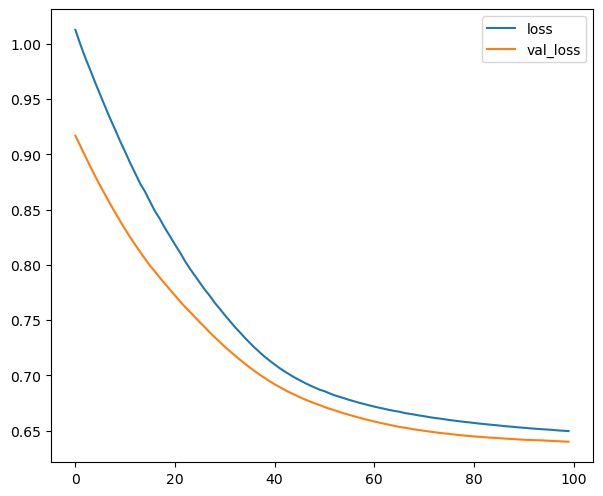

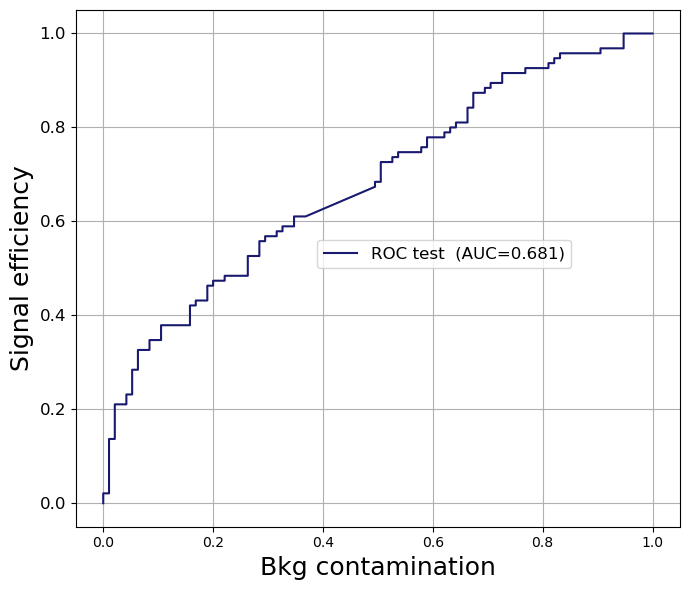

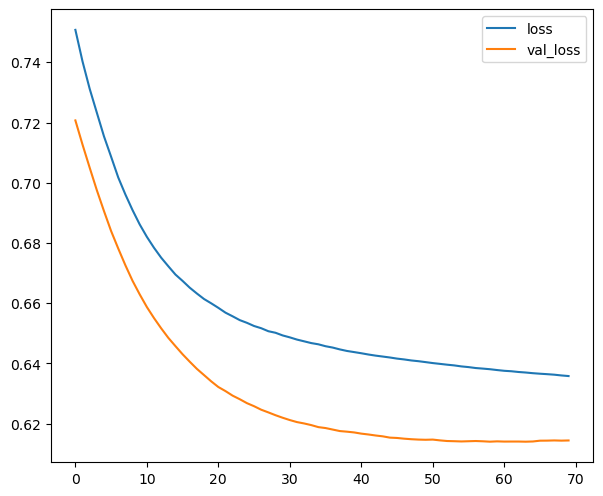

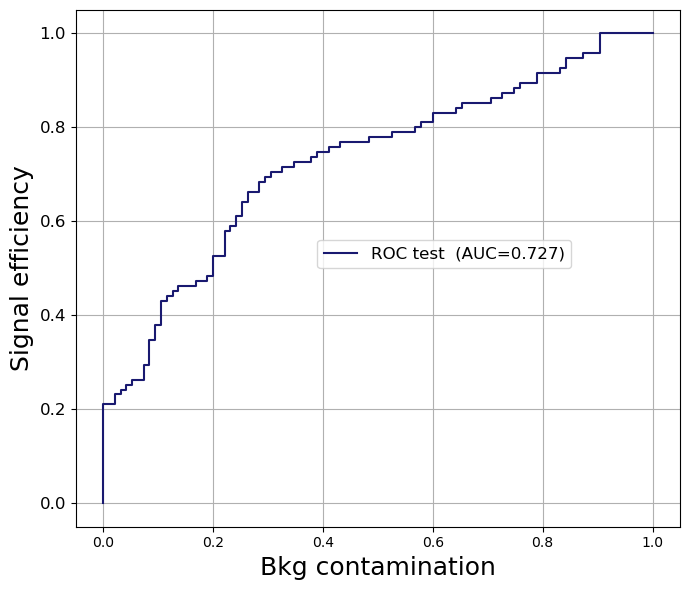

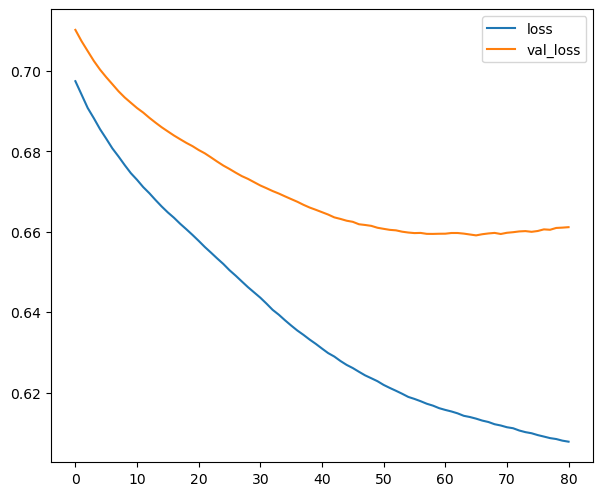

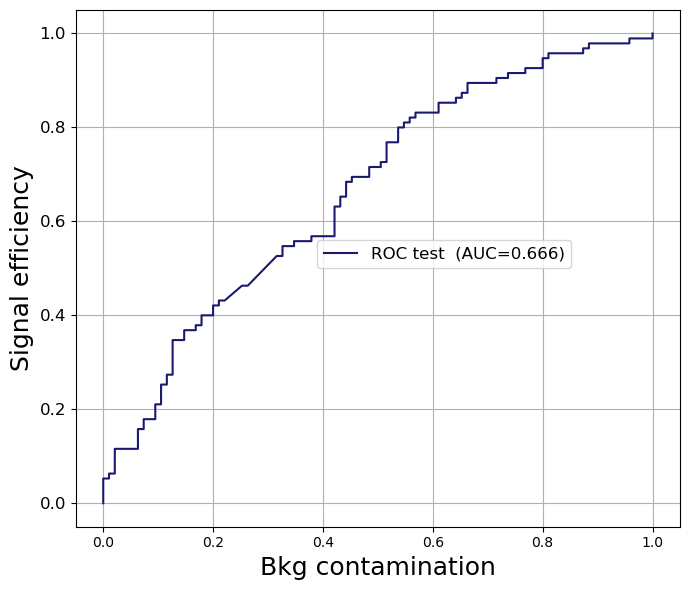

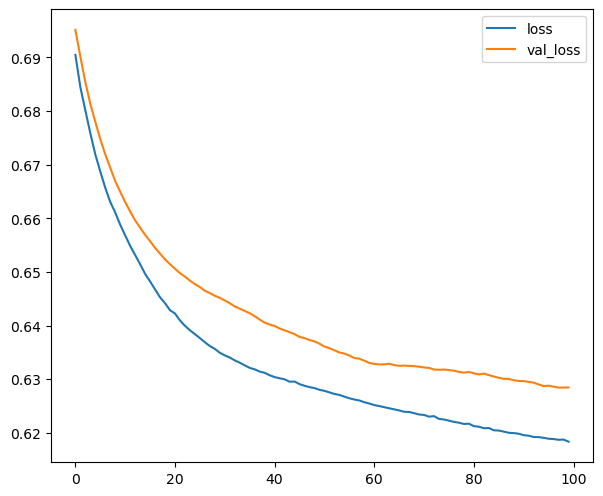

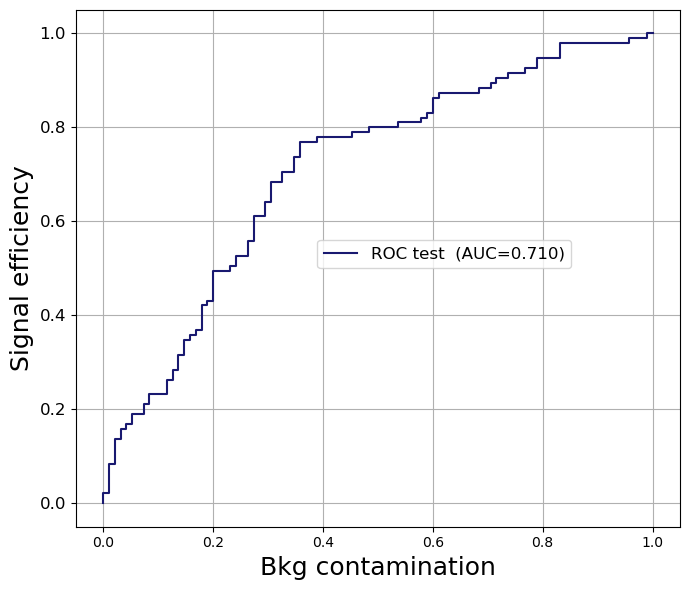

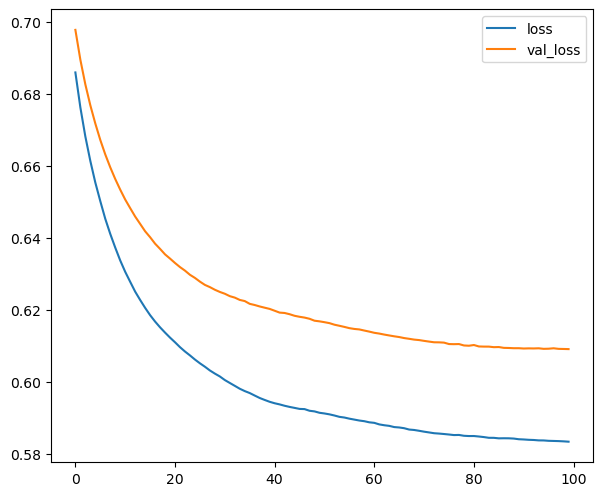

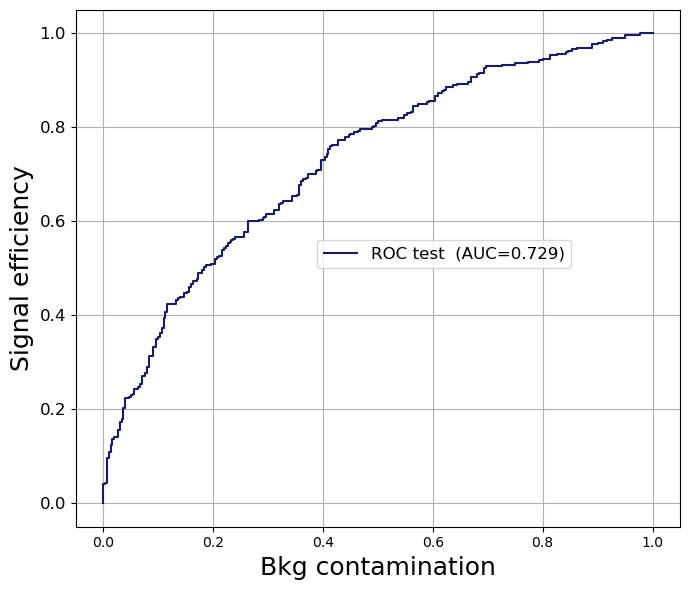

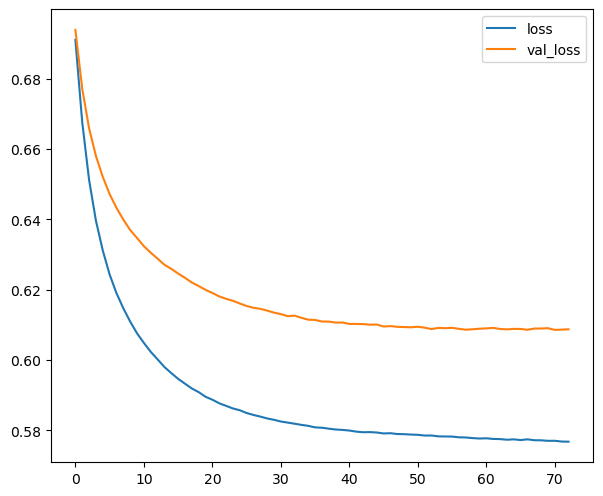

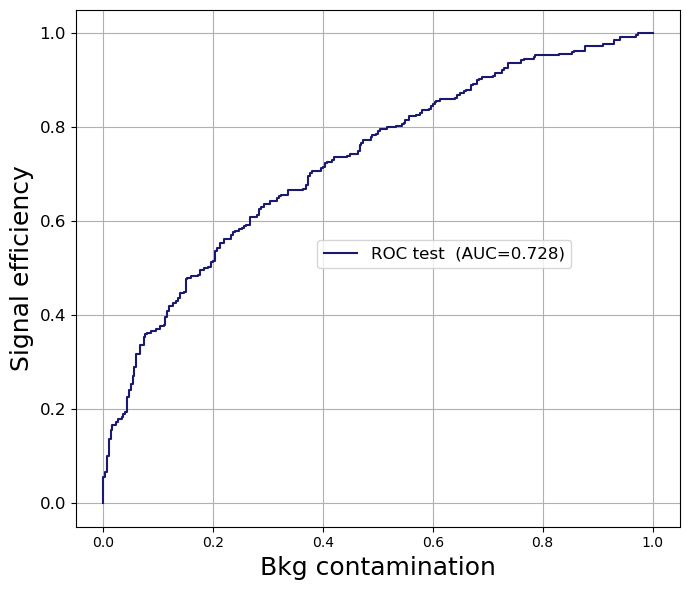

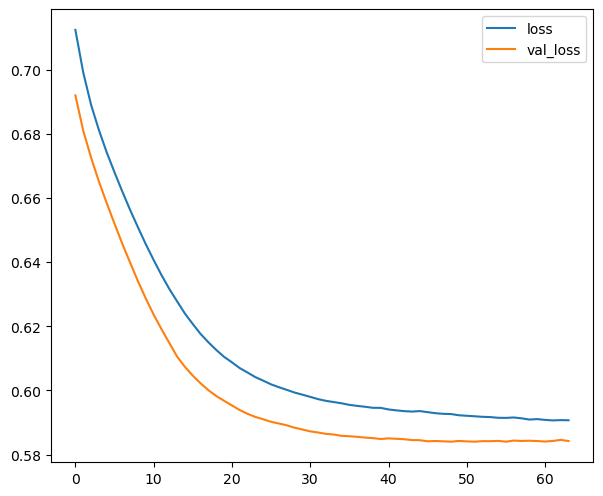

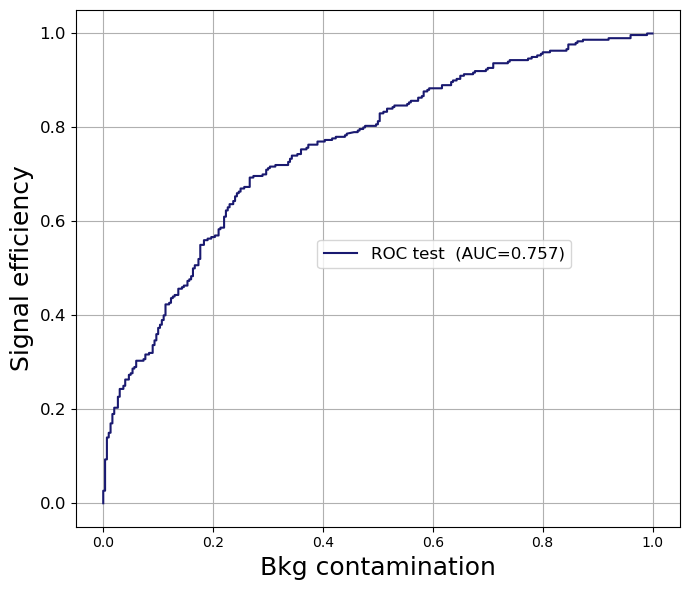

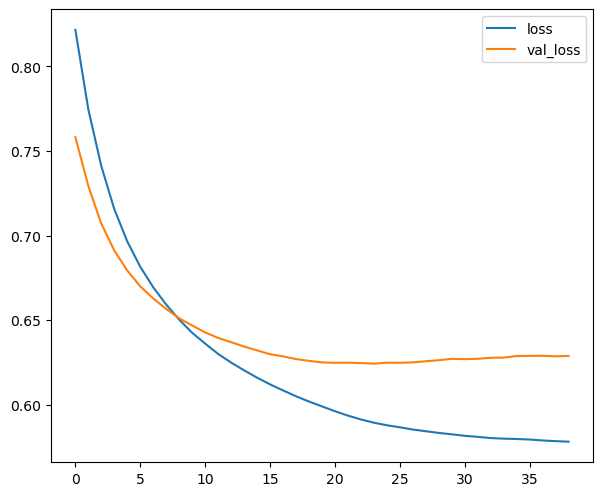

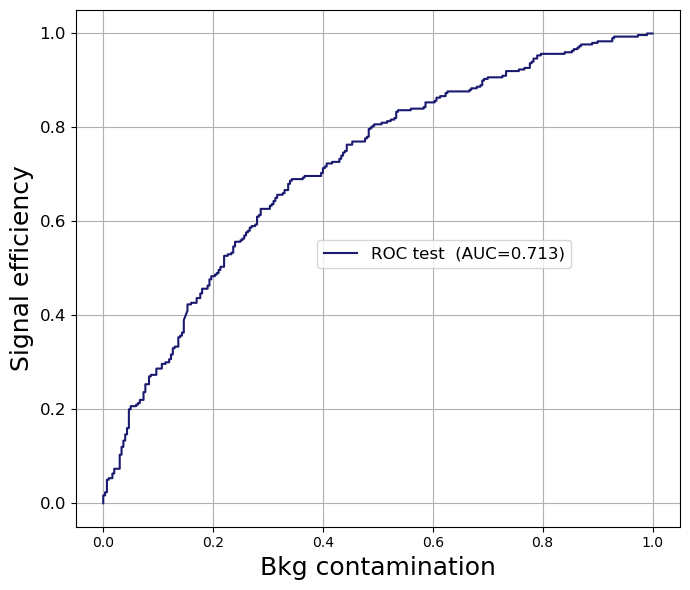

In [12]:
#use_weights = True
for N in [int(x) for x in np.logspace(2.5,3,2)]:  #(a,b,c) c numbers from 10^a to 10^b
    print(N)
    for nlayer in [1,2]:
        for nnodes in [4,8]:
            print(nlayer,nnodes)
            run(nlayer,nnodes, N, "results_train_stella.csv",100, False)
            #run(nlayer,nnodes, N, "results_Aurora_weights.csv",100, use_weights) if use_weights==True else run(nlayer,nnodes, N, "results_Aurora_noweights.csv", 100,use_weights)

In [14]:
df = pd.read_csv("results_train_stella.csv",sep=";", names=["name", "layers", "nodes", "nvars", "ntrain", "auc_val", "auc_train", "epochs"])

In [15]:
df

,name,layers,nodes,nvars,ntrain,auc_val,auc_train,epochs
0,3l_128_5var,3,128,5,316,0.674571,0.720337,100
1,4l_64_5var,4,64,5,316,0.678116,0.726889,100
2,4l_128_5var,4,128,5,316,0.688864,0.773735,100
3,3l_64_5var,3,64,5,630,0.741749,0.745667,100
4,3l_128_5var,3,128,5,630,0.746928,0.751688,100
5,4l_64_5var,4,64,5,630,0.706195,0.773181,100
6,4l_128_5var,4,128,5,630,0.726435,0.761910,100
7,3l_64_5var,3,64,5,1000,0.755067,0.761582,100
8,3l_128_5var,3,128,5,1000,0.754567,0.768039,100
9,4l_64_5var,4,64,5,1000,0.763311,0.763649,100


In [19]:
import matplotlib.pyplot as plt
#import mplhep as hep
#plt.style.use(hep.style.CMS)
# Overall - both left and right annotation

ModuleNotFoundError: No module named 'mplhep'

AttributeError: 'DataFrame' object has no attribute 'nodes'

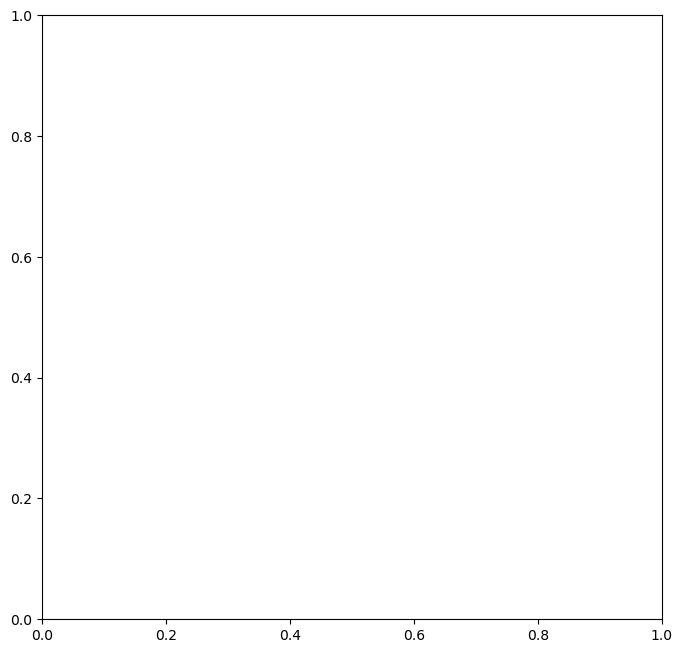

In [26]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small")
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000) & (df.nvars> 2)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 64)                384       
_________________________________________________________________
dense_109 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_110 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_111 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 1s 125ms/step - loss: 0.6862 - accuracy: 0.5588 - val_loss: 0.67

103/110 [===========================>..] - ETA: 0s - loss: 0.6012 - accuracy: 0.6810

KeyboardInterrupt: 

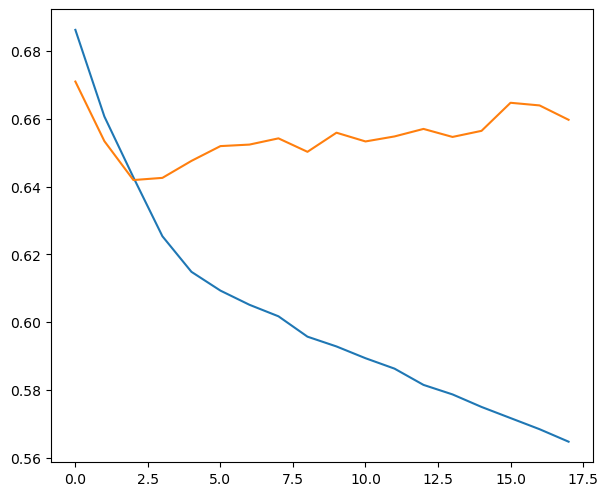

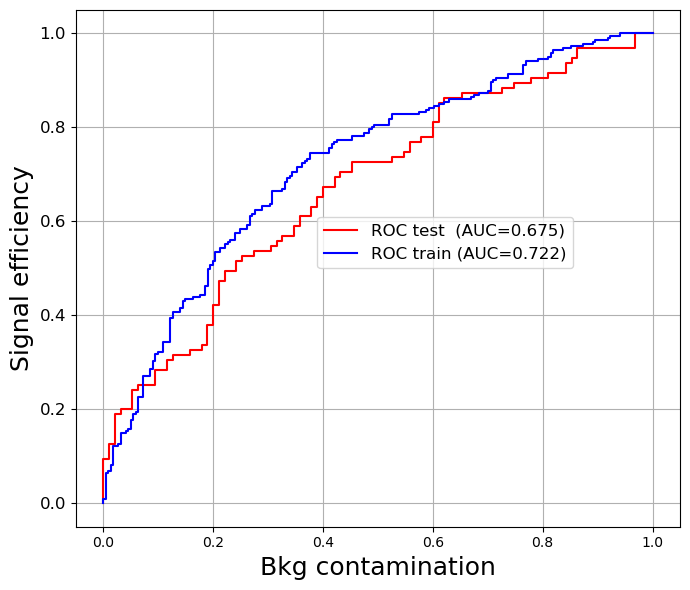

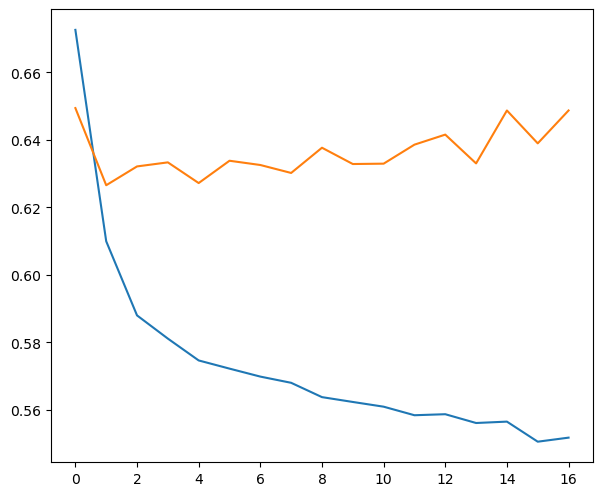

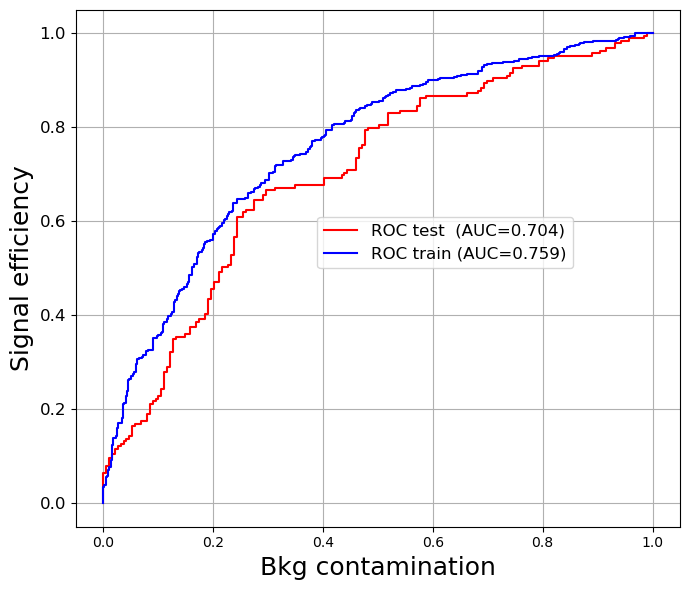

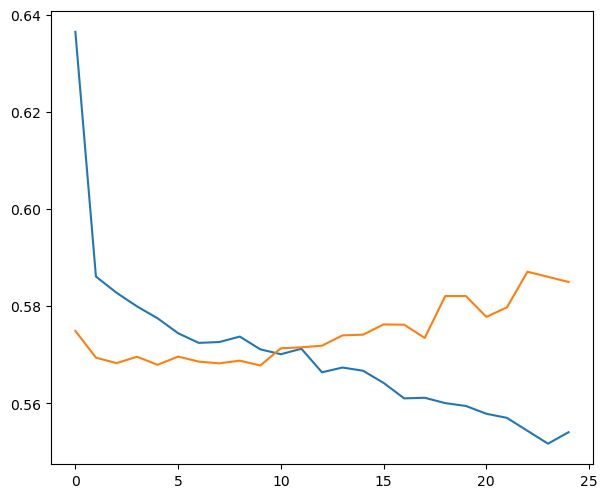

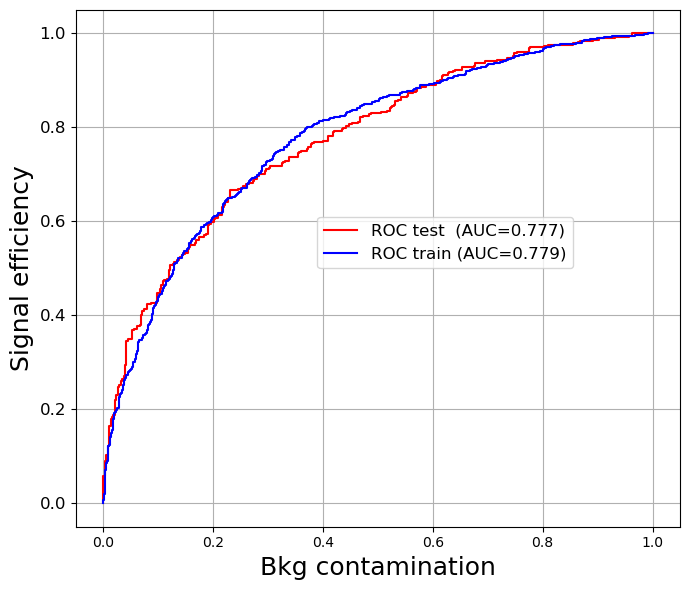

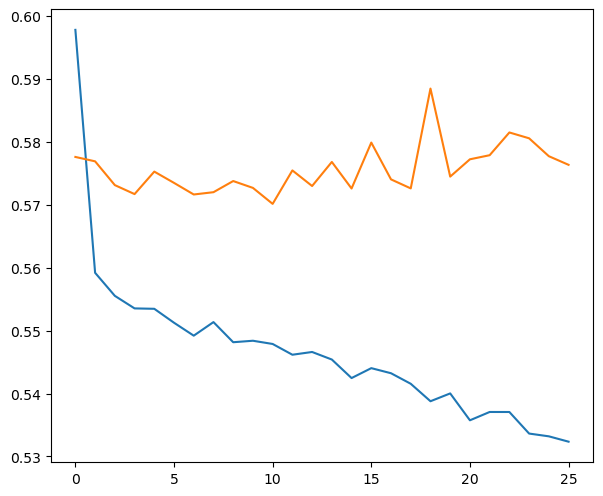

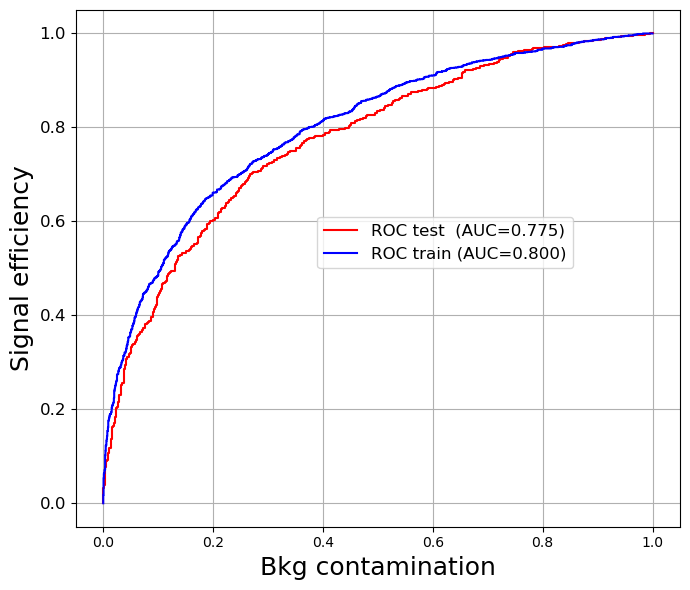

In [27]:
for N in [int(x) for x in np.logspace(2.5, 4,6)]:
    #print(N)
    run(4,64, N,"results_weights_ntrain.csv")

Text(0, 0.5, 'AUC')

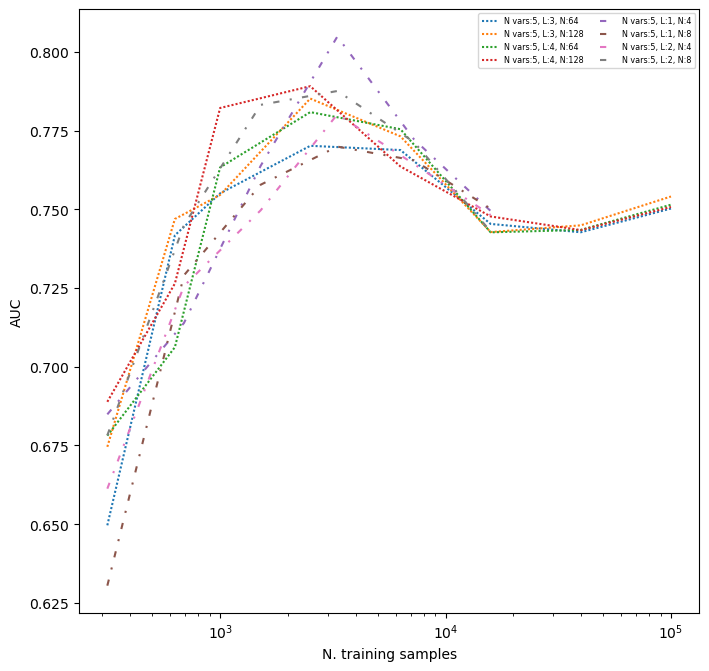

In [56]:
df = pd.read_csv("results_train_stella.csv",sep=";")

fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nvar in [5]:
    for arch in [[3,64],[3,128],[4,64],[4,128]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[0][1])
for nvar in [5]:
    for arch in [[1,4],[1,8],[2,4],[2,8]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xscale("log")
ax1.set_xlabel("N. training samples")
ax1.set_ylabel("AUC")

### Kolmogorov test

In [19]:
from random import randint
#funzione per convertire un array di array in una lista
def Nto1Darray(array): 
    list=[]
    for i in range(len(array)):
        list.append(array[i][0])
    return list

#funzione per fare plot e calcolare kstest
from scipy.stats import kstest
def KStest(test,train, output=True):
    n_bins=20
    n_s,bin_s,patches_s = plt.hist(test, bins=n_bins, label='signal',density=True, color=(0, 0.48, 0.72,0.8))
    n_b,bin_b,patches_b = plt.hist(train, bins=n_bins,histtype='step', label='background',density=True, color='red')
    plt.legend()
    if output==True:
        plt.title("Output")
        print("Kolmogorov test result for the output variables: ",kstest(test,train))
    else:
        plt.title("Input")
        print("Kolmogorov test result for the input variables: ",kstest(test,train))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 48        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
110/110 [==============================] - 1s 4ms/step - loss: 0.7062 - accuracy: 0.5504 - val_loss: 0.6725 - val_accuracy: 0.5960
Epoch 2/30
110/110 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6196 - val_loss: 0.6376 - val_accuracy: 0.6433
Epoch 3/30
110/110 [==============================] - 0s 1ms/step - loss: 0.6245 - accuracy: 0.6571 - val_loss: 0.6204 - val_accuracy: 0.6607
Epoch 4/30
110/110 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0

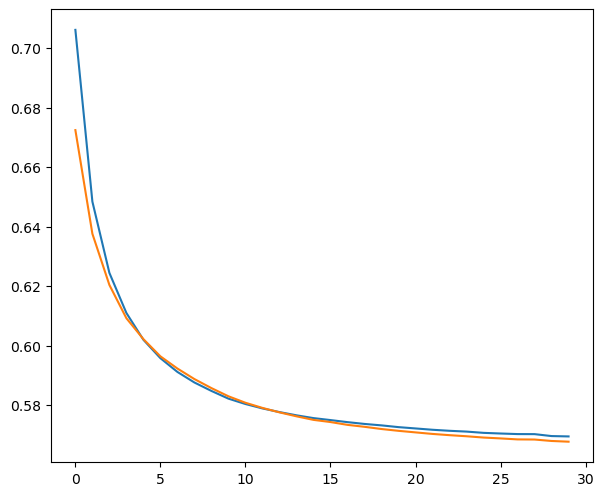

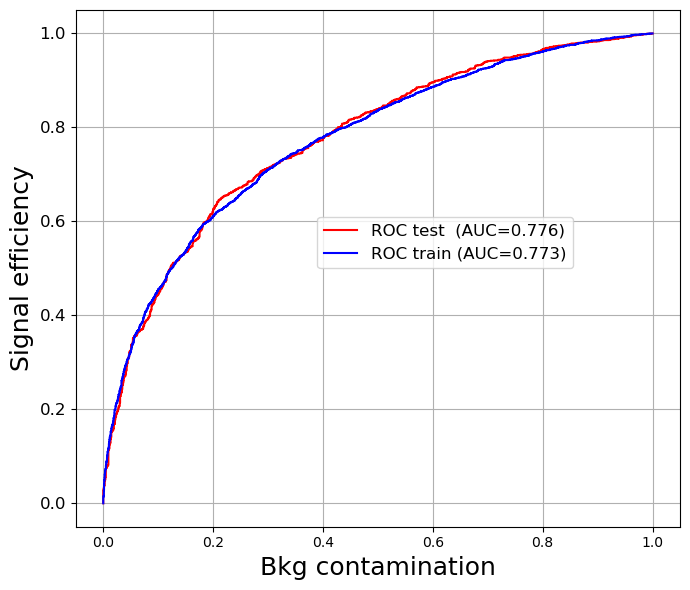

In [20]:
X_test, X_train, pred_test, pred_train = run(1,8,5000, "kstest.csv", 30,False)

### Plot of input and output variables

Kolmogorov test result for the input variables:  KstestResult(statistic=0.01680952380952381, pvalue=0.5874487729604312)
Kolmogorov test result for the output variables:  KstestResult(statistic=0.023095238095238096, pvalue=0.209560405553342)


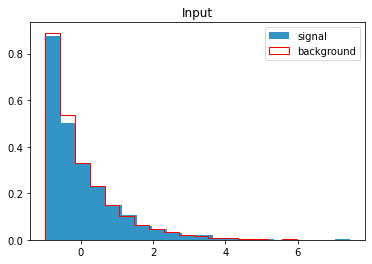

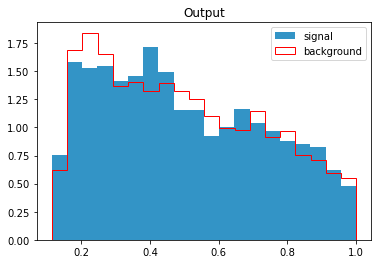

In [21]:
p_test = Nto1Darray(pred_test)
p_train = Nto1Darray(pred_train)
x_train = Nto1Darray(X_train)
x_test = Nto1Darray(X_test)

KStest(x_test,x_train,False)
plt.figure()
KStest(p_test,p_train)

with open("kstest.csv","a") as o:
    o.write("{};{};{};{}\n".format(kstest(x_test,x_train)[0],kstest(x_test,x_train)[1], kstest(p_test,p_train)[0], kstest(p_test,p_train)[1]))

### scatter plot of pT vs Energy

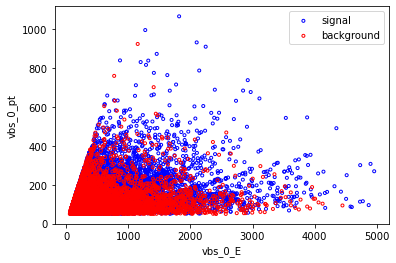

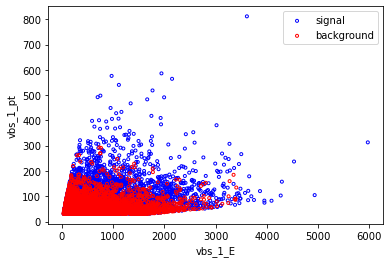

<Figure size 432x288 with 0 Axes>

In [34]:
# for this part use "cols": ["vbs_0_E","vbs_1_E","vbs_0_pt","vbs_1_pt"]
for j in range(0,2):
    vbs_sig_E = []
    vbs_bkg_E = []
    vbs_sig_pt = []
    vbs_bkg_pt = []
    for i in range(0,5000):
        vbs_sig_E.append(X_sig[i,j])
        vbs_bkg_E.append(X_bkg[i,j])
        vbs_sig_pt.append(X_sig[i,j+2])
        vbs_bkg_pt.append(X_bkg[i,j+2])
    plt.scatter(vbs_sig_E, vbs_sig_pt, marker=".", facecolors='none', edgecolors='b', label='signal')
    plt.scatter(vbs_bkg_E, vbs_bkg_pt, marker=".", facecolors='none', edgecolors='r', label='background')
    #plt.xlim(0,7000)
    #plt.ylim(0,7000)
    plt.xlabel("vbs_0_E") if j==0 else plt.xlabel("vbs_1_E")
    plt.ylabel("vbs_0_pt") if j==0 else plt.ylabel("vbs_1_pt")
    plt.legend()
    plt.show()
    plt.figure()

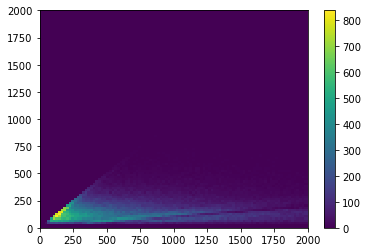

In [36]:
plt.hist2d(vbs_sig_E,vbs_sig_pt, range=((0,2000),(0,2000)), bins=(100,100))
plt.colorbar()

#plt.hist(W_train[y_train==0], bins=50)
#plt.hist(W_train[y_train==1], bins=50)